In [60]:
# Day 3 – SQL via Python: NYC School Data Exploration

#You’ll connect to a PostgreSQL database and answer three questions:
#1) Number of schools per borough  
#2) Average % of English Language Learners (ELL) per borough  
#3) Top 3 schools per borough by % of special education students (SPED)  

import os, pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()
conn_str = f"postgresql+psycopg2://{os.getenv('PGUSER')}:{os.getenv('PGPASSWORD')}@{os.getenv('PGHOST')}:{os.getenv('PGPORT')}/{os.getenv('PGDATABASE')}?sslmode={os.getenv('PGSSLMODE','require')}"
engine = create_engine(conn_str, pool_pre_ping=True)
with engine.connect() as conn:
    print(conn.execute(text("SELECT 1")).scalar())


1


In [61]:
import sys; sys.executable


'C:\\Users\\aminm\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\python.exe'

In [62]:
DIR  = "nyc_schools.high_school_directory"
DEM  = "nyc_schools.school_demographics"


In [63]:
## Q1 — Number of schools per borough
#Counts distinct DBNs in the high school directory grouped by `borough`.
#import pandas as pd
#from sqlalchemy import text

q1 = """
SELECT borough, COUNT(DISTINCT dbn) AS school_count
FROM nyc_schools.high_school_directory
GROUP BY borough
ORDER BY school_count DESC;
"""
df_q1 = pd.read_sql(text(q1), engine)
display(df_q1)


,borough,school_count
0,Brooklyn,121
1,Bronx,118
2,Manhattan,106
3,Queens,80
4,Staten Island,10


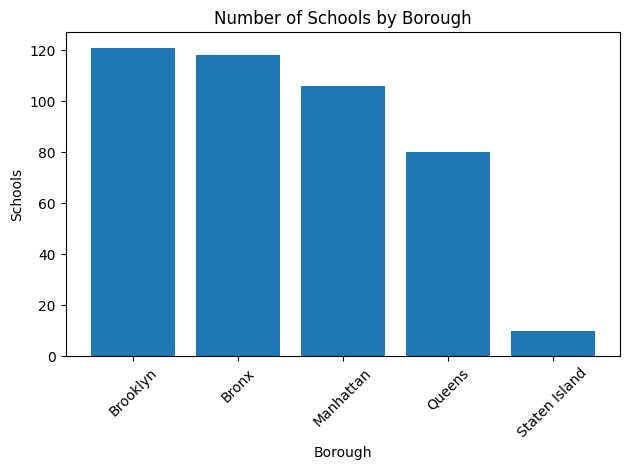

In [64]:
import matplotlib.pyplot as plt

x = df_q1['borough']
y = df_q1['school_count']

plt.figure()
plt.bar(x, y)
plt.title('Number of Schools by Borough')
plt.xlabel('Borough'); plt.ylabel('Schools')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [65]:
## Q2 — Average % ELL per borough (latest year **per school**)
#We take the most recent `schoolyear` for each DBN (so every borough is represented), then average `ell_percent` by borough.

import pandas as pd
from sqlalchemy import text

q2_simple = f"""
SELECT d.borough,
       ROUND(AVG(sd.ell_percent::numeric), 2) AS avg_ell_percent
FROM {DIR} d
JOIN {DEM} sd ON d.dbn = sd.dbn
GROUP BY d.borough
ORDER BY d.borough;
"""
df_q2 = pd.read_sql(text(q2_simple), engine)
display(df_q2.round(2))


,borough,avg_ell_percent
0,Manhattan,7.57


In [66]:
## Q3 — Top 3 schools per borough by % SPED (latest year **per school**)
#Rank schools within each borough by `sped_percent` and keep the top 3.

from sqlalchemy import text
import pandas as pd

q3 = text("""
WITH ranked AS (
  SELECT
    d.borough,
    d.school_name,
    d.dbn,
    sd.schoolyear,
    sd.sped_percent::numeric AS sped_percent,
    ROW_NUMBER() OVER (
      PARTITION BY d.borough
      ORDER BY sd.sped_percent::numeric DESC NULLS LAST
    ) AS rn
  FROM nyc_schools.high_school_directory d
  JOIN nyc_schools.school_demographics sd
    ON d.dbn = sd.dbn
  WHERE sd.sped_percent IS NOT NULL
)
SELECT
  borough, school_name, dbn, schoolyear, ROUND(sped_percent, 2) AS sped_percent
FROM ranked
WHERE rn <= 3
ORDER BY borough, rn;
""")

df_q3 = pd.read_sql(q3, engine)  # یا conn اگر از connection استفاده می‌کنی
display(df_q3)



,borough,school_name,dbn,schoolyear,sped_percent
0,Manhattan,East Side Community School,01M450,20092010,28.8
1,Manhattan,East Side Community School,01M450,20102011,27.7
2,Manhattan,East Side Community School,01M450,20082009,26.7


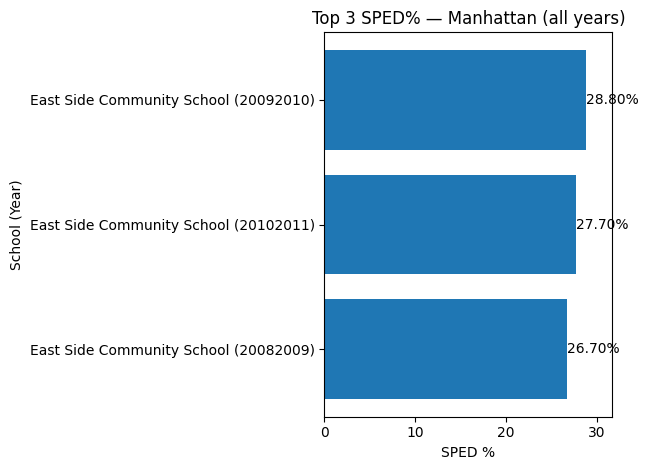

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df_q3.copy()
df_plot["sped_percent"] = pd.to_numeric(df_plot["sped_percent"], errors="coerce")
df_plot["label"] = df_plot.apply(lambda r: f"{r['school_name']} ({r['schoolyear']})", axis=1)

for b, g in df_plot.groupby("borough"):
    g = g.sort_values("sped_percent", ascending=True)
    plt.figure()
    bars = plt.barh(g["label"], g["sped_percent"])
    plt.title(f"Top 3 SPED% — {b} (all years)")
    plt.xlabel("SPED %")
    plt.ylabel("School (Year)")
    xmax = (g["sped_percent"].max() or 0) * 1.10
    plt.xlim(0, xmax if xmax > 0 else 1)
    for bar, v in zip(bars, g["sped_percent"].tolist()):
        if pd.notna(v):
            plt.text(v, bar.get_y() + bar.get_height()/2, f"{v:.2f}%", va="center", ha="left")
    plt.tight_layout()
    plt.show()



Here’s a cleaned-up summary that matches your latest (all-years, per-borough, no-aggregation) queries:

Q1) Brooklyn (121) and the Bronx (118) have the most schools in the dataset; Staten Island has the fewest (10).

Q2) Only Manhattan currently has demographic rows that join to the directory.
The average share of English Language Learners (ELL) in Manhattan is 7.57% (across 40 matched schools).
For the Bronx, Brooklyn, Queens, and Staten Island there are no matched demographics in this snapshot.

Q3) Using the “all years, per borough” query (no last-year filter, no aggregation), the top-3 rows all come from Manhattan and the same school across different years:

East Side Community School — 28.8% (2009–2010)

East Side Community School — 27.7% (2010–2011)

East Side Community School — 26.7% (2008–2009)

    